<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIC-402 Lab 7: Deep-learning Based Unsupervised Learning

CMKL University

By Sarun Gulyanon


### Goal

Explore deep learning approaches for unsupervised learning, with a focus on representation learning using autoencoders and variational autoencoders (VAEs).

### Outline

In this lab, we provide example code covering the following topics:
1. Unsupervised representation learning with autoencoders, and the use of learned latent representations for downstream tasks
2. Using Variational Autoencoders (VAEs) to generate new samples

----



## 1. Import Package and Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

np.random.seed(1000)
tf.random.set_seed(1000)

Load the data and split it into training and test sets.

In [2]:
data = fetch_olivetti_faces()
X = data.images.astype("float32")  # (400, 64, 64), already scaled to [0,1]
X = X[..., None]                   # (400, 64, 64, 1)
y = data.target                    # (400,), person ID 0..39

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1000, stratify=y)

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(X_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 2. Autoencoder

An autoencoder is an unsupervised neural network that learns compact representations of data. It consists of an **encoder**, which compresses the input into a low-dimensional latent vector, and a **decoder**, which reconstructs the original input from this representation. By minimizing reconstruction error, the model learns meaningful features that can be reused for downstream tasks such as classification.

We begin by defining the model architectures for the encoder and decoder.


In [3]:
latent_dim = 20

# Encoder
enc_in = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(enc_in)   # 32x32
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)        # 16x16
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)       # 8x8
x = layers.Flatten()(x)
z = layers.Dense(latent_dim, name="latent")(x)
encoder = keras.Model(enc_in, z, name="encoder")

# Decoder
dec_in = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(dec_in)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 16x16
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 32x32
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 64x64
dec_out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(dec_in, dec_out, name="decoder")

# Autoencoder
ae_in = enc_in
ae_out = decoder(encoder(ae_in))
autoencoder = keras.Model(ae_in, ae_out, name="autoencoder")

Configure the model to use the Adam optimizer and mean squared error as the loss function.

In [4]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
)

In [5]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 20)             │       256,532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 1)      │       412,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,693 (2.55 MB)

 Trainable params: 668,693 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [6]:
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=32,
    verbose=1,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.0316 - val_loss: 0.0307
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0301 - val_loss: 0.0281
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255 - val_loss: 0.0221
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209 - val_loss: 0.0200
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0186 - val_loss: 0.0186
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.

Visualize reconstructions

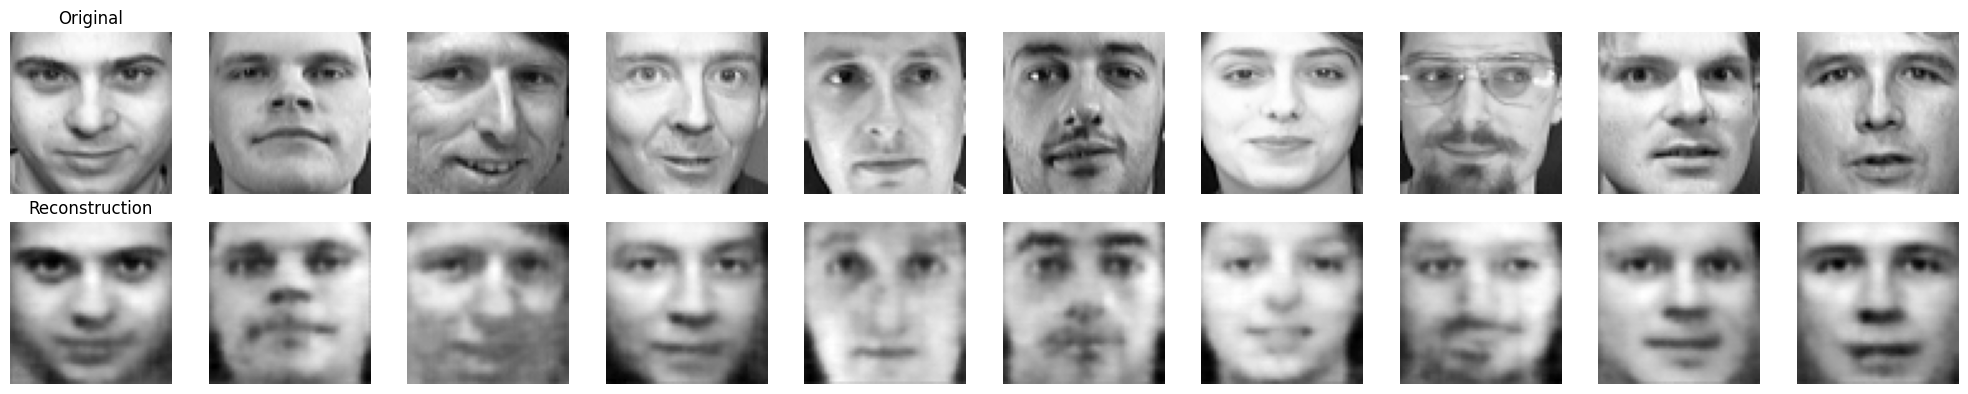

In [7]:
def show_recon(model, X, n=10):
    idx = np.random.choice(len(X), size=n, replace=False)
    x = X[idx]
    x_hat = model.predict(x, verbose=0)

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

        # recon
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(x_hat[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

show_recon(autoencoder, X_val, n=10)

Plot training curve

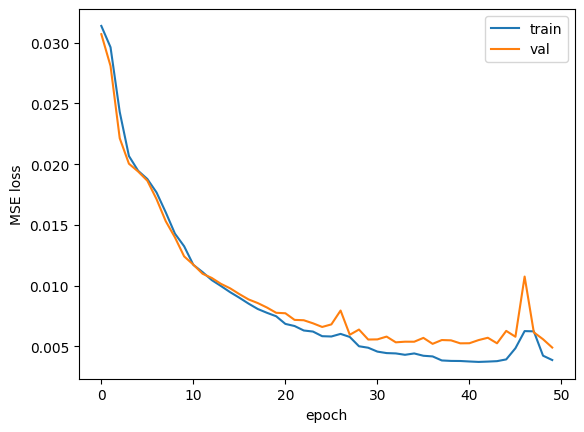

In [8]:
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

## 2.1 Downstream Task

We apply logistic regression on top of the learned encoder representations from the Olivetti Faces dataset. This step assumes that the autoencoder has already been trained and the encoder is used to extract latent feature vectors for classification.


In [9]:
# encoder outputs shape (N, latent_dim)
Z_train = encoder.predict(X_train, batch_size=64, verbose=0)
Z_val  = encoder.predict(X_val,  batch_size=64, verbose=0)


# Apply logistic regression
clf = LogisticRegression(max_iter=5000)
clf.fit(Z_train, y_train)

# Evaluate
y_pred = clf.predict(Z_val)

print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_val, y_pred)))

Accuracy score:0.96


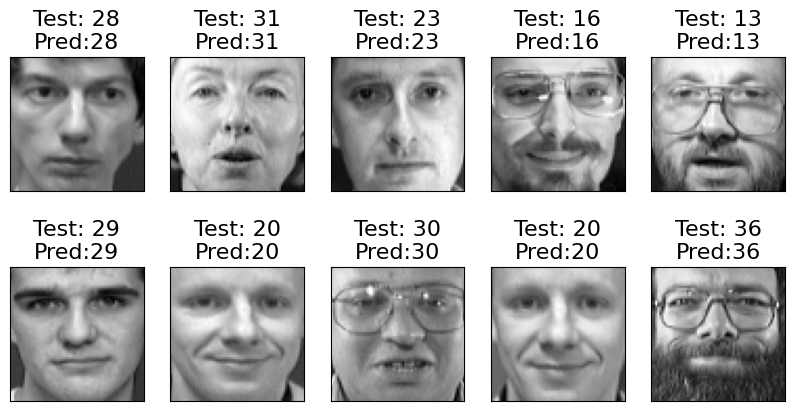

In [10]:
plt.figure(figsize=(10,5))
for i in range(10):
    image, label, pred = X_val[i+20], y_val[i+20], y_pred[i+20]
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(image, (64,64)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Test: {label}\nPred:{pred}', fontsize = 16)
    plt.grid(False)

In [11]:
cm = metrics.confusion_matrix(y_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

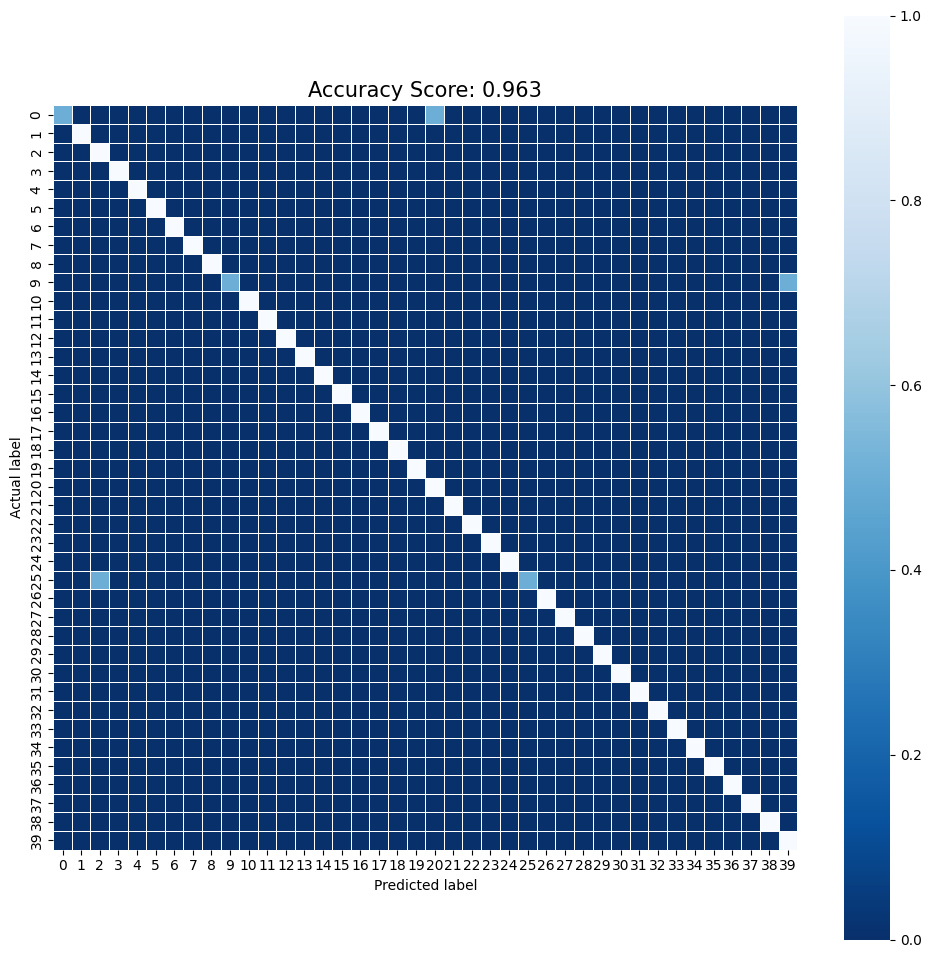

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(cm_normalized,
            linewidths=.5,
            square = True,
            cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(metrics.accuracy_score(y_val, y_pred))
plt.title(all_sample_title, size = 15);

# 3. VAE

A Variational Autoencoder (VAE) is a generative neural network that learns a probabilistic latent representation of data. Instead of encoding each input into a single point, a VAE maps inputs to a distribution in latent space and is trained to both reconstruct the input and regularize the latent space to follow a known prior (typically a standard normal distribution). This enables VAEs to generate new samples by sampling from the latent space while learning meaningful, smooth representations.

We begin by defining the architectures of the encoder and decoder networks.

In [13]:
latent_dim = 20

# Encoder: 64x64x1 -> z_mean, z_logvar
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)  # 32x32
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)               # 16x16
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)              # 8x8
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_logvar], name="encoder")
encoder.summary()

# Decoder: z -> 64x64x1
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 16x16
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 32x32
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 64x64
decoder_outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,097,408 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 20)        │      5,140 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 20)        │      5,140 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,200,360 (8.39 MB)

 Trainable params: 2,200,360 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8192)           │       172,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,161 (1.57 MB)

 Trainable params: 412,161 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Implement the custom Keras model for VAE. Training optimizes a combined objective consisting of a reconstruction loss, which encourages accurate reconstructions, and a KL divergence term, which regularizes the latent space to follow a standard normal distribution.

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def sample_z(self, z_mean, z_logvar):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_logvar = self.encoder(x, training=True)
            z = self.sample_z(z_mean, z_logvar)
            x_hat = self.decoder(z, training=True)

            # Reconstruction loss: BCE per pixel, sum over pixels, mean over batch
            recon = tf.keras.losses.binary_crossentropy(x, x_hat)  # (B, 64, 64)
            recon_loss = tf.reduce_mean(tf.reduce_sum(recon, axis=(1, 2)))

            # KL divergence: mean over batch
            kl = -0.5 * (1.0 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl, axis=1))

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, x):
        z_mean, z_logvar = self.encoder(x, training=False)
        z = self.sample_z(z_mean, z_logvar)
        x_hat = self.decoder(z, training=False)

        recon = tf.keras.losses.binary_crossentropy(x, x_hat)
        recon_loss = tf.reduce_mean(tf.reduce_sum(recon, axis=(1, 2)))

        kl = -0.5 * (1.0 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl, axis=1))

        total_loss = recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def call(self, x, training=False):
        z_mean, z_logvar = self.encoder(x, training=training)
        z = self.sample_z(z_mean, z_logvar)
        return self.decoder(z, training=training)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))

Train the model

In [15]:
history = vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - kl_loss: 0.1386 - loss: 2832.1475 - recon_loss: 2832.0088 - val_kl_loss: 1.7283 - val_loss: 2808.6992 - val_recon_loss: 2806.9707
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 4.8884 - loss: 2795.2056 - recon_loss: 2790.3174 - val_kl_loss: 3.5024 - val_loss: 2766.4246 - val_recon_loss: 2762.9219
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - kl_loss: 3.6213 - loss: 2760.2056 - recon_loss: 2756.5845 - val_kl_loss: 5.2888 - val_loss: 2757.7170 - val_recon_loss: 2752.4280
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 5.0244 - loss: 2757.2705 - recon_loss: 2752.2458 - val_kl_loss: 5.8656 - val_loss: 2752.8142 - val_recon_loss: 2746.9485
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 5.4697 - loss: 2752.7603 - recon_loss: 2747.2905 - val_kl_loss: 5.7141 - val_loss: 2745.2566 - val_recon_loss: 2739.5427
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 5.7656 - loss: 2749.52

Visualize reconstructions

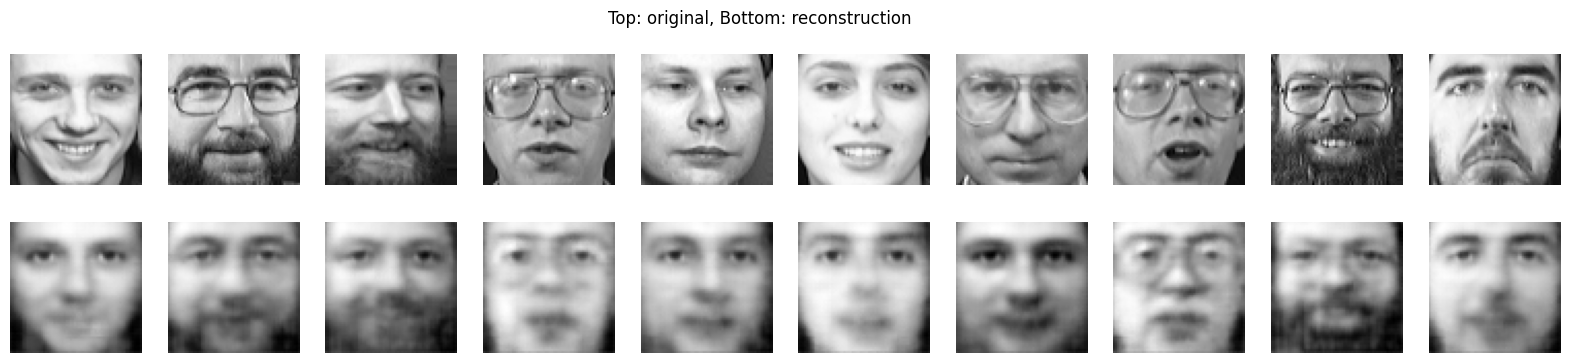

In [16]:
def show_reconstructions(model, x, n=10):
    x = x[:n]
    x_hat = model(x, training=False).numpy()

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x[i, :, :, 0], cmap="gray")
        plt.axis("off")
        # Reconstructed
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_hat[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Top: original, Bottom: reconstruction")
    plt.show()

show_reconstructions(vae, X_val, n=10)

Sample new faces from latent prior

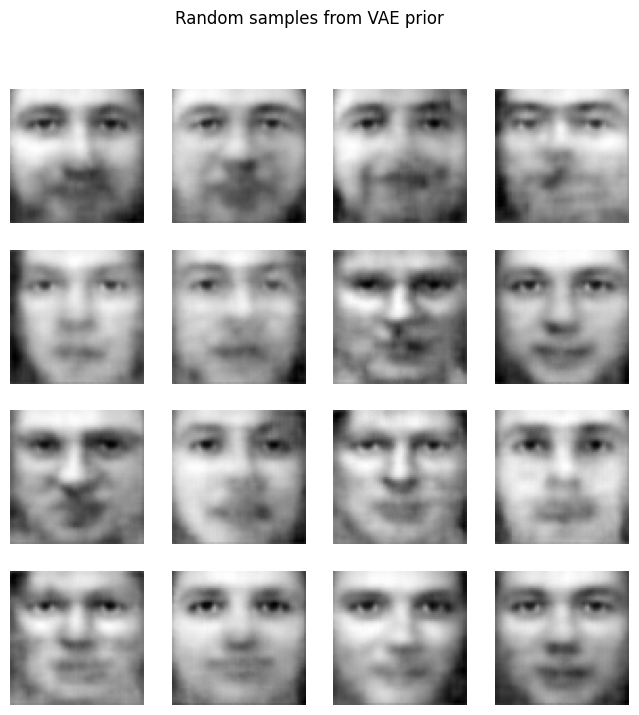

In [17]:
def sample_faces(decoder, latent_dim, n=16):
    z = tf.random.normal(shape=(n, latent_dim))
    imgs = decoder(z, training=False).numpy()

    k = int(np.ceil(np.sqrt(n)))
    plt.figure(figsize=(2*k, 2*k))
    for i in range(n):
        ax = plt.subplot(k, k, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Random samples from VAE prior")
    plt.show()

sample_faces(decoder, latent_dim, n=16)

----